In [523]:
import pandas as pd
import cPickle as pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandas.tools.plotting import scatter_matrix
from ast import literal_eval 
from collections import defaultdict
import datetime

# analysis
import statsmodels.api as sm
from scipy.stats import pearsonr
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import normalize, scale, StandardScaler, Normalizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import scale
from sklearn.feature_selection import VarianceThreshold
from sklearn.grid_search import GridSearchCV

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [5]:
"""to dos:
- try normalizing features
- other features to include:
    - tips given by user
    - network of friends - number of elite friends?
- grid search parameters for random forest 
- correlation matrix? 
- sentiment analysis on tips?
"""

'to dos:\n- try normalizing features\n- other features to include:\n    - tips given by user\n    - network of friends - number of elite friends?\n'

In [91]:
biz = pd.read_csv('data/yelp_academic_dataset_business.csv')
bizkeep = [c for c in biz.columns if 'attributes' not in c and 'hours' not in c]
biz = biz[bizkeep]

//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (1,4,7,17,29,49,60,62,79,86,94) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Las Vegas                         17423
Phoenix                           10629
Charlotte                          5189
Scottsdale                         5139
Montréal                           3891
Pittsburgh                         3337
Edinburgh                          3272
Mesa                               3190
Henderson                          2839
Tempe                              2773
Chandler                           2425
Madison                            2104
Glendale                           1823
Gilbert                            1716
Peoria                              929
Karlsruhe                           898
North Las Vegas                     819
Surprise                            587
Champaign                           462
Goodyear                            459
Avondale                            386
Queen Creek                         348
Matthews                            346
Waterloo                            262
Urbana                              262


In [37]:
users = pd.read_csv('data/yelp_academic_dataset_user.csv')

In [38]:
# add total votes and compliments
voteslist = [col for col in list(users.columns) if 'votes' in col]
compslist = [col for col in list(users.columns) if 'compliments' in col]
users['votes'] = users[voteslist].sum(axis = 1)
users['comps'] = users[compslist].sum(axis = 1)

In [39]:
# add total elite years
users.elite = users.elite.apply(lambda x: literal_eval(x)) # don't rerun this
users['elite_yrs'] = users.elite.apply(lambda x: len(x))

In [40]:
# add total friends
users.friends = users.friends.apply(lambda x: literal_eval(x)) # don't rerun this
users['friends_num'] = users.friends.apply(lambda x: len(x))

In [41]:
# add elite yes/no
users['is_elite'] = users.elite.apply(lambda x: 1 if len(x) > 0 else 0)

In [42]:
# add time on yelp
users['yelping_since'] = pd.to_datetime(users.yelping_since)
users['yrs_yelping'] = users.yelping_since.apply(
    lambda x: datetime.datetime.now().year - x.year)

In [368]:
# log transform variables
def log_transform(stat):
    if stat > 0:
        return np.log(stat)
    elif stat == 0:
        return np.log(stat + .001)
    else:
        return np.log(1 + stat)

In [12]:
users['review_count_log'] = users.review_count.apply(log_transform)
users['friends_num_log'] = users.friends_num.apply(log_transform)
users['votes_log'] = users.votes.apply(log_transform)
users['comps_log'] = users.comps.apply(log_transform)
users['elite_yrs_log'] = users.elite_yrs.apply(log_transform)
users['fans_log'] = users.fans.apply(log_transform)

In [44]:
users['votes_avg'] = users.apply(
    lambda row: row.votes / row.review_count if row.review_count > 0 else 0, 
    axis = 1) # don't rerun
users['comps_avg'] = users.apply(
    lambda row: row.comps / row.review_count if row.review_count > 0 else 0, 
    axis = 1) # don't rerun
users['votes_avg_log'] = users.votes_avg.apply(log_transform)
users['comps_avg_log'] = users.comps_avg.apply(log_transform)

add tips data & transform

In [ ]:
# add tips data
tips = pd.read_csv('data/yelp_academic_dataset_tip.csv')
usertips = pd.DataFrame(tips.user_id.value_counts())
usertips.columns = ['tips']
users = users.merge(usertips, how = 'left', left_on = 'user_id', right_index = True)
users.tips.fillna(0, inplace = True)

In [78]:
users['tips_log'] = users.tips.apply(log_transform)

In [576]:
tips = pd.read_csv('data/yelp_academic_dataset_tip.csv')

In [581]:
users.is_elite.value_counts()[1] / float(users.shape[0])

0.056959584602934064

add friends network data

In [58]:
eliteusers = users[['user_id', 'is_elite']]
eliteusers.set_index('user_id', inplace = True)
elite_dict = eliteusers.to_dict()['is_elite']

In [70]:
# find number of elite friends
def get_num_elite_friends(flist):
    return sum(map(lambda x: elite_dict[x], flist))

In [73]:
users['elite_friends_num'] = users.friends.apply(get_num_elite_friends)
users['pct_friends_elite'] = users.loc[:,'elite_friends_num'] / users.loc[:,'friends_num']

In [87]:
users['elite_friends_log'] = users.elite_friends_num.apply(log_transform)

add review text data & transform

In [106]:
# add review text data
with open('pickled/user_avgs.pkl', 'r') as picklefile:
    reviews = pickle.load(picklefile)

In [115]:
users = users.merge(reviews, how = 'left', left_on = 'user_id', right_index = True)

In [119]:
users.rename(columns = {
        'review_len_wrds' : 'avg_wrds_per_rev',
        'review_len_sent' : 'avg_sent_per_rev',
        'num_para' : 'avg_num_para',
        'mentions_price' : 'freq_mentions_price',
        'num_allcaps' : 'avg_num_allcaps',
        'num_exclamations' : 'avg_num_excl'
    }, inplace = True)

In [15]:
# log transform
rev_features = ['avg_wrds_per_rev', 'avg_sent_per_rev', 'avg_wrds_in_sent', 'avg_num_para',
                  'freq_mentions_price', 'avg_num_allcaps', 'avg_num_excl']
for feature in rev_features:
    users[feature + '_log'] = users[feature].apply(log_transform)

In [131]:
# ARI scores
with open('pickled/user_ari.pkl', 'r') as picklefile:
    ari = pickle.load(picklefile)

In [137]:
users = users.merge(ari, how = 'left', left_on = 'user_id', right_index = True)

In [224]:
# set all ari scores < -5 to floor of -5
users.ari_score[users.ari_score < -5.0] = -5

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [228]:
users['ari_log'] = users.loc[:,'ari_score'].apply(log_transform)

In [ ]:
"""interpreting ARI scores: 
- very high = run on sentences
- negative = short reviews with short sentences and short words 
"""

In [203]:
# add average word length
with open('pickled/user_wrdlength.pkl', 'r') as picklefile:
    chars = pickle.load(picklefile)

In [206]:
chars = pd.DataFrame(chars)

In [208]:
users = users.merge(chars, how = 'left', left_on = 'user_id', right_index = True)

In [360]:
# add review content
with open('pickled/user_content.pkl', 'r') as picklefile:
    content = pickle.load(picklefile)

In [361]:
content = pd.DataFrame(content)

In [363]:
users = users.merge(content, how = 'left', left_on = 'user_id', right_index = True)

In [371]:
users['net_elite_wrds'] = users.loc[:,'num_elite_words'] - users.loc[:, 'num_ne_words']

In [374]:
# log transform
users['elite_wrds_log'] = users.num_elite_words.apply(log_transform)
users['ne_words_log'] = users.num_ne_words.apply(log_transform)

transform detailed compliments/votes

In [383]:
# get list of cols
comps_features = [col for col in users.columns if "compliments" in col]
votes_features = [col for col in users.columns if "votes." in col]

In [412]:
# fill in na
users[comps_features] = users[comps_features].fillna(0)
users[votes_features] = users[votes_features].fillna(0)

In [413]:
for feature in comps_features + votes_features:
    users[feature + '_log'] = users[feature].apply(log_transform)

pickle & save

In [77]:
# pickle when adding more data processing
with open('pickled/userdata.pkl', 'w') as picklefile:
    pickle.dump(users, picklefile)

In [3]:
# load when restarting kernel
with open('pickled/userdata.pkl', 'r') as picklefile:
    users = pickle.load(picklefile)

In [375]:
users.columns

Index([          u'yelping_since',       u'compliments.plain',
                  u'review_count',                 u'friends',
              u'compliments.cute',      u'compliments.writer',
                          u'fans',        u'compliments.note',
                          u'type',         u'compliments.hot',
              u'compliments.cool',     u'compliments.profile',
                 u'average_stars',        u'compliments.more',
                         u'elite',                    u'name',
                       u'user_id',              u'votes.cool',
              u'compliments.list',             u'votes.funny',
            u'compliments.photos',       u'compliments.funny',
                  u'votes.useful',                   u'votes',
                         u'comps',               u'elite_yrs',
                   u'friends_num',                u'is_elite',
                   u'yrs_yelping',        u'review_count_log',
               u'friends_num_log',               u'vote

### some charts

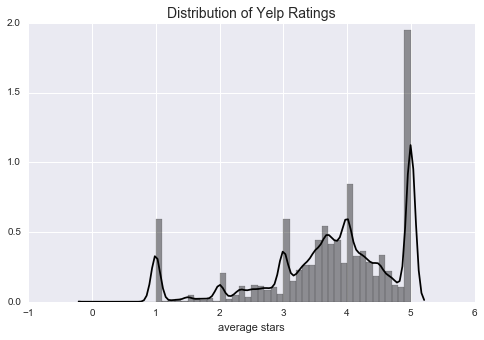

In [21]:
plt.figure(figsize = (8, 5))
sns.distplot(users.average_stars, color = 'black')
plt.title('Distribution of Yelp Ratings', fontsize = 14)
plt.xlabel('average stars')
plt.savefig('ratings-dist.png', dpi = 800)
plt.show()

In [51]:
onereview = users[users.review_count == 1]

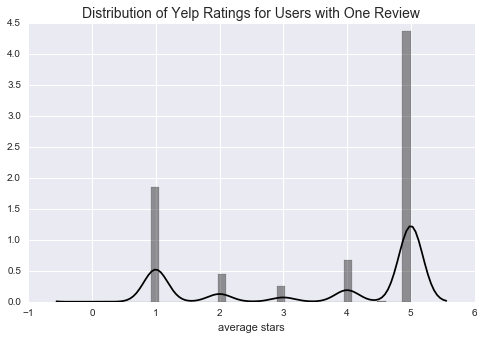

In [52]:
plt.figure(figsize = (8, 5))
sns.distplot(onereview.average_stars, color = 'black')
plt.title('Distribution of Yelp Ratings for Users with One Review', fontsize = 14)
plt.xlabel('average stars')
#plt.savefig('ratings-dist.png', dpi = 800)
plt.show()

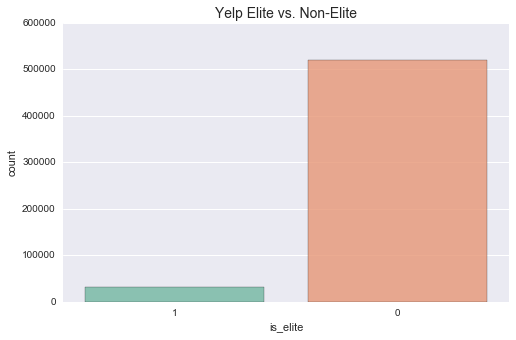

In [19]:
plt.figure(figsize = (8, 5))
sns.countplot('is_elite', data = users, palette = "Set2", alpha = 0.8)
plt.title('Yelp Elite vs. Non-Elite', fontsize = 14)
plt.savefig('elite.png', dpi = 800)
plt.show()

In [95]:
users.is_elite.value_counts()

0    520878
1     31461
Name: is_elite, dtype: int64

In [30]:
byelite = users.groupby('is_elite')
byelite[log_features].describe()

yrs_yelping  review_count_log       fans_log  \
is_elite                                                         
0        count  520878.000000     520878.000000  520878.000000   
         mean        3.915214          1.748980      -5.459800   
         std         2.057897          1.300174       2.940529   
         min         0.000000         -6.907755      -6.907755   
         25%         2.000000          0.693147      -6.907755   
         50%         4.000000          1.609438      -6.907755   
         75%         5.000000          2.639057      -6.907755   
         max        12.000000          8.671287       5.789960   
1        count   31461.000000      31461.000000   31461.000000   
         mean        6.257080          5.149113       1.736127   
         std         2.176835          0.795085       2.003505   
         min         1.000000          0.000000      -6.907755   
         25%         5.000000          4.595120       1.098612   
         50%         6.000000          5.117994       1.945910   
         75%         8.000000          5.673323       2.708050   
         max        12.000000          9.241839       7.412764   

                friends_num_log      votes_log      comps_log  average_stars  
is_elite                                                                      
0        count    520878.000000  520878.000000  520878.000000  520878.000000  
         mean         -3.493251       0.580805      -4.543420       3.737392  
         std           4.086290       3.831415       3.650934       1.098230  
         min          -6.907755      -6.907755      -6.907755       0.000000  
         25%          -6.907755       0.000000      -6.907755       3.180000  
         50%          -6.907755       1.791759      -6.907755       3.920000  
         75%           0.693147       3.044522       0.000000       4.600000  
         max           7.516977      11.561363      12.260906       5.000000  
1        count     31461.000000   31461.000000   31461.000000   31461.000000  
         mean          2.984856       6.281183       4.051766       3.803845  
         std           1.750939       1.217793       1.729612       0.290653  
         min          -6.907755       1.609438      -6.907755       1.390000  
         25%           2.197225       5.463832       3.044522       3.620000  
         50%           3.091042       6.188264       3.951244       3.800000  
         75%           3.988984       6.998510       4.990433       4.000000  
         max           8.245909      11.945461      11.075164       5.000000

In [23]:
users.is_elite.value_counts()[1] 
#/ float(users.is_elite.count())

31461

In [98]:
userids = list(users.user_id)

In [102]:
eliteusers.head()

,user_id,is_elite
0,18kPq7GPye-YQ3LyKyAZPw,1
1,rpOyqD_893cqmDAtJLbdog,1
2,4U9kSBLuBDU391x6bxU-YA,1
3,fHtTaujcyKvXglE33Z5yIw,0
4,SIBCL7HBkrP4llolm4SC2A,1


In [100]:
with open('pickled/userids_list.pkl', 'w') as picklefile:
    pickle.dump(userids, picklefile)

In [40]:
with open('pickled/users_elite.pkl', 'w') as picklefile:
    pickle.dump(eliteusers, picklefile)

### feature selection

variance threshold

In [124]:
vt = VarianceThreshold(threshold = 0.75)
x_new = vt.fit_transform(users[log_features])

In [129]:
kept = vt.get_support(indices = True) # get indices of features selected

In [130]:
# features without significant variance
removed = [i for i in range(users[log_features].shape[1]) if i not in kept]
for i in removed:
    print i, users[log_features].columns[i]

8 avg_wrds_per_rev_log
9 avg_sent_per_rev_log
10 avg_wrds_in_sent_log
11 avg_num_para_log


### classification model

In [ ]:
"""FEATURE TYPES
- review structure (words, sents, etc)
- review sentiment (average stars, star distribution) - maybe excl and all caps?
- activity (reviews, tips)
- social network (friends, fans)
- recognition (votes, compliments)"""

In [95]:
def eval_models(features, df, estimators):
    acc_scores = []
    p_scores = []
    r_scores = []
    for est in estimators: 
        xtrain, xtest, ytrain, ytest = train_test_split(
            df[features], df.is_elite, test_size = .25)
        m = est.fit(xtrain, ytrain)
        acc_scores.append(cross_val_score(est, xtrain, ytrain, cv = 10).mean())
        p_scores.append(cross_val_score(est, xtrain, ytrain, cv = 10, scoring = 'precision').mean())
        r_scores.append(cross_val_score(est, xtrain, ytrain, cv = 10, scoring = 'recall').mean())
        print 'done with %s' %str(est).split('(')[0]
    return zip([str(x).split('(')[0] for x in estimators], acc_scores, p_scores, r_scores)

In [484]:
def eval_models_pl(features, df, estimators):
    acc_scores = []
    p_scores = []
    r_scores = []
    auc_scores = []
    for est in estimators: 
        xtrain, xtest, ytrain, ytest = train_test_split(
            df[features], df.is_elite, test_size = .25)
        pipeline = make_pipeline(StandardScaler(), est)
        #m = est.fit(xtrain, ytrain)
        acc_scores.append(cross_val_score(pipeline, xtrain, ytrain, cv = 5).mean())
        p_scores.append(cross_val_score(pipeline, xtrain, ytrain, cv = 5, scoring = 'precision').mean())
        r_scores.append(cross_val_score(pipeline, xtrain, ytrain, cv = 5, scoring = 'recall').mean())
        auc_scores.append(cross_val_score(pipeline, xtrain, ytrain, cv = 5, scoring = 'roc_auc').mean())
        print 'done with %s' %str(est).split('(')[0]
    return zip([str(x).split('(')[0] for x in estimators], acc_scores, p_scores, r_scores, auc_scores)

In [22]:
def eval_models_classes(estimators, xtrain, xtest, ytrain, ytest):
    acc_scores = []
    p_scores = []
    r_scores = []
    for est in estimators: 
        m = est.fit(xtrain, ytrain)
        pred = m.predict(xtrain)
        print '\n', str(est).split('(')[0]
        print m.classes_
        print 'accuracy:', accuracy_score(ytrain, pred)
        print 'precision:', precision_score(ytrain, pred, average = None)
        print 'recall:', recall_score(ytrain, pred, average = None)
        print 'f1:', f1_score(ytrain, pred, average = None)

In [415]:
def eval_models_incr(features, df, est):
    """Get accuracy, precision, and recall for all 
    feature combinations.
    Args:
    features (list) -- list of features
    df (df) -- df
    est -- estimator to use 
    Returns:
    (features, accuracy, precision, recall)
    """
    feats = []
    acc_scores = []
    p_scores = []
    r_scores = []
    for i in range(0, len(features)):
        feats.append(features[:i+1])
    #df = df.dropna(subset = features)
    for feat in feats:
        xtrain, xtest, ytrain, ytest = train_test_split(
            df[feat], df.is_elite, test_size = .25)
        pipeline = make_pipeline(StandardScaler(), est)
        acc = cross_val_score(pipeline, xtrain, ytrain, cv = 5).mean()
        p = cross_val_score(pipeline, xtrain, ytrain, cv = 5, scoring = 'precision').mean()
        r = cross_val_score(pipeline, xtrain, ytrain, cv = 5, scoring = 'recall').mean()
        acc_scores.append(acc)
        p_scores.append(p)
        r_scores.append(r)
        print feat
        print 'acc:', acc
        print 'precision:', p
        print 'recall:', r, '\n'
#     return zip(feats, acc_scores, p_scores, r_scores)

In [245]:
# model set up
log_features = ['review_count_log', 'tips_log', 'yrs_yelping', 
                'comps_log', 'votes_log', 'fans_log', 'elite_friends_log', 
                'average_stars',
                'avg_chars_per_word', 'avg_wrds_in_sent_log', 
                'avg_sent_per_rev_log', 'avg_num_para_log',
                'freq_mentions_price_log', 'avg_num_allcaps_log', 'avg_num_excl_log']

In [423]:
edited_features = ['review_count_log', 'yrs_yelping',
                'comps_log', 'fans_log', 'elite_friends_log',
                'votes.cool_log', 'votes.funny_log', 'votes.useful_log',
                'average_stars',
                'elite_wrds_log', 'ne_words_log',
                'avg_chars_per_word', 'avg_wrds_in_sent_log', 
                'avg_sent_per_rev_log',
                'freq_mentions_price_log', 'avg_num_allcaps_log']

# edited_features = ['review_count_log', 'yrs_yelping',
#                 'comps_log', 'fans_log', 'friends_num_log', 
#                 'average_stars',
#                 'avg_sent_per_rev_log', 'avg_wrds_in_sent_log', 
#                   'freq_mentions_price_log', 'avg_num_allcaps_log']

In [24]:
Xtrain, Xtest, ytrain, ytest = train_test_split(
    users[log_features], users.is_elite, test_size = .25)

In [242]:
# best model = with separate char per wrd, wrd per sent, sent per rev
eval_models(edited_features, users, [LogisticRegression()])

done with LogisticRegression


[('LogisticRegression',
  0.97600022446037704,
  0.8176260182242967,
  0.74619709366711406)]

In [262]:
# best model = with separate char per wrd, wrd per sent, sent per rev - try with normalization
eval_models_pl(edited_features, users, [LogisticRegression()])

done with LogisticRegression


[('LogisticRegression',
  0.97492842971844529,
  0.80425122881457356,
  0.74047304472444364)]

In [424]:
eval_models_pl(edited_features, users, [best_sgd, best_rf, best_logit])

done with SGDClassifier
done with RandomForestClassifier
done with LogisticRegression


[('SGDClassifier',
  0.97602678585225999,
  0.8225976029702764,
  0.74976619555885959),
 ('RandomForestClassifier',
  0.9779507242134734,
  0.83223842163906858,
  0.76165175639094973),
 ('LogisticRegression',
  0.97643475004721425,
  0.82031901569548782,
  0.74816865417376488)]

make pipeline

In [257]:
pipeline = make_pipeline(Normalizer(), SGDClassifier(loss = 'log'))

In [ ]:
cross_val_score(pipeline, X_train, y_train)

**sgd classifier**

grid search

In [427]:
Xtrain, Xtest, ytrain, ytest = train_test_split(
    users[edited_features], users.is_elite, test_size = .25)

In [443]:
def grid_search_scores(Xtrain, ytrain):
    scores = ['accuracy', 'precision', 'recall', 'f1']
    output = defaultdict(list)
    pipeline = make_pipeline(StandardScaler(), SGDClassifier())
    param = {
        'sgdclassifier__loss': ['hinge', 'log', 'squared_hinge'],
        'sgdclassifier__penalty': ['l1', 'l2', 'elasticnet', 'none'],
        'sgdclassifier__alpha': 10.0**-np.arange(3,7),
        'sgdclassifier__n_iter': [50]}
    for score in scores: 
        print score, '\n'
        grid_search = GridSearchCV(pipeline, param_grid = param, verbose = 3, cv = 5, scoring = score)
        grid_search.fit(Xtrain, ytrain)
        output[score] = grid_search.grid_scores_
    return output      

In [474]:
def grid_search_scores_auc(Xtrain, ytrain):
    scores = ['roc_auc']
    output = defaultdict(list)
    pipeline = make_pipeline(StandardScaler(), SGDClassifier())
    param = {
        'sgdclassifier__loss': ['hinge', 'log', 'squared_hinge'],
        'sgdclassifier__penalty': ['l1', 'l2', 'elasticnet', 'none'],
        'sgdclassifier__alpha': 10.0**-np.arange(3,7),
        'sgdclassifier__n_iter': [50]}
    for score in scores: 
        print score, '\n'
        grid_search = GridSearchCV(pipeline, param_grid = param, verbose = 3, cv = 5, scoring = score)
        grid_search.fit(Xtrain, ytrain)
        output[score] = grid_search.grid_scores_
    return output   

In [449]:
def grid_search_scores_rf(Xtrain, ytrain):
    scores = ['accuracy', 'precision', 'recall', 'f1']
    output = defaultdict(list)
    pipeline = make_pipeline(StandardScaler(), RandomForestClassifier())
    param = {
        'randomforestclassifier__max_features': ['auto', 'log2', None],
        'randomforestclassifier__min_samples_leaf': [1, 5, 10, 50, 100, 200, 500]}
    for score in scores: 
        print score, '\n'
        grid_search = GridSearchCV(pipeline, param_grid = param, verbose = 3, cv = 5, scoring = score)
        grid_search.fit(Xtrain, ytrain)
        output[score] = sorted(grid_search.grid_scores_, reverse = True)
    return output 

In [479]:
def grid_search_scores_rf_auc(Xtrain, ytrain):
    scores = ['roc_auc']
    output = defaultdict(list)
    pipeline = make_pipeline(StandardScaler(), RandomForestClassifier())
    param = {
        'randomforestclassifier__max_features': ['auto', 'log2', None],
        'randomforestclassifier__min_samples_leaf': [1, 5, 10, 50, 100, 200, 500]}
    for score in scores: 
        print score, '\n'
        grid_search = GridSearchCV(pipeline, param_grid = param, verbose = 3, cv = 5, scoring = score)
        grid_search.fit(Xtrain, ytrain)
        output[score] = (grid_search.best_params_, sorted(grid_search.grid_scores_, reverse = True))
    return output 

#### sgd classifier

In [475]:
auc_sgd_scores = grid_search_scores_auc(Xtrain, ytrain)

roc_auc 

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] sgdclassifier__penalty=l1, sgdclassifier__alpha=0.001, sgdclassifier__n_iter=50, sgdclassifier__loss=hinge 
[CV]  sgdclassifier__penalty=l1, sgdclassifier__alpha=0.001, sgdclassifier__n_iter=50, sgdclassifier__loss=hinge, score=0.989317 -   4.9s
[CV] sgdclassifier__penalty=l1, sgdclassifier__alpha=0.001, sgdclassifier__n_iter=50, sgdclassifier__loss=hinge 
[CV]  sgdclassifier__penalty=l1, sgdclassifier__alpha=0.001, sgdclassifier__n_iter=50, sgdclassifier__loss=hinge, score=0.989683 -   4.1s
[CV] sgdclassifier__penalty=l1, sgdclassifier__alpha=0.001, sgdclassifier__n_iter=50, sgdclassifier__loss=hinge 
[CV]  sgdclassifier__penalty=l1, sgdclassifier__alpha=0.001, sgdclassifier__n_iter=50, sgdclassifier__loss=hinge, score=0.989979 -   4.3s
[CV] sgdclassifier__penalty=l1, sgdclassifier__alpha=0.001, sgdclassifier__n_iter=50, sgdclassifier__loss=hinge 
[CV]  sgdclassifier__penalty=l1, sgdclassifier__alpha=0.001, s

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:  2.3min
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:  9.2min



[CV] sgdclassifier__penalty=l2, sgdclassifier__alpha=1e-05, sgdclassifier__n_iter=50, sgdclassifier__loss=hinge 
[CV]  sgdclassifier__penalty=l2, sgdclassifier__alpha=1e-05, sgdclassifier__n_iter=50, sgdclassifier__loss=hinge, score=0.990318 -   3.3s
[CV] sgdclassifier__penalty=l2, sgdclassifier__alpha=1e-05, sgdclassifier__n_iter=50, sgdclassifier__loss=hinge 
[CV]  sgdclassifier__penalty=l2, sgdclassifier__alpha=1e-05, sgdclassifier__n_iter=50, sgdclassifier__loss=hinge, score=0.990131 -   3.2s
[CV] sgdclassifier__penalty=l2, sgdclassifier__alpha=1e-05, sgdclassifier__n_iter=50, sgdclassifier__loss=hinge 
[CV]  sgdclassifier__penalty=l2, sgdclassifier__alpha=1e-05, sgdclassifier__n_iter=50, sgdclassifier__loss=hinge, score=0.990147 -   3.5s
[CV] sgdclassifier__penalty=elasticnet, sgdclassifier__alpha=1e-05, sgdclassifier__n_iter=50, sgdclassifier__loss=hinge 
[CV]  sgdclassifier__penalty=elasticnet, sgdclassifier__alpha=1e-05, sgdclassifier__n_iter=50, sgdclassifier__loss=hinge, sco

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 18.2min finished


In [444]:
gs_scores = grid_search_scores(Xtrain, ytrain)

accuracy 

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] sgdclassifier__penalty=l1, sgdclassifier__alpha=0.001, sgdclassifier__n_iter=50, sgdclassifier__loss=hinge 
[CV]  sgdclassifier__penalty=l1, sgdclassifier__alpha=0.001, sgdclassifier__n_iter=50, sgdclassifier__loss=hinge, score=0.975546 -   4.3s
[CV] sgdclassifier__penalty=l1, sgdclassifier__alpha=0.001, sgdclassifier__n_iter=50, sgdclassifier__loss=hinge 
[CV]  sgdclassifier__penalty=l1, sgdclassifier__alpha=0.001, sgdclassifier__n_iter=50, sgdclassifier__loss=hinge, score=0.974931 -   4.0s
[CV] sgdclassifier__penalty=l1, sgdclassifier__alpha=0.001, sgdclassifier__n_iter=50, sgdclassifier__loss=hinge 
[CV]  sgdclassifier__penalty=l1, sgdclassifier__alpha=0.001, sgdclassifier__n_iter=50, sgdclassifier__loss=hinge, score=0.976922 -   4.1s
[CV] sgdclassifier__penalty=l1, sgdclassifier__alpha=0.001, sgdclassifier__n_iter=50, sgdclassifier__loss=hinge 
[CV]  sgdclassifier__penalty=l1, sgdclassifier__alpha=0.001, 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:  2.1min
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:  8.0min



[CV] sgdclassifier__penalty=l2, sgdclassifier__alpha=1e-05, sgdclassifier__n_iter=50, sgdclassifier__loss=hinge 
[CV]  sgdclassifier__penalty=l2, sgdclassifier__alpha=1e-05, sgdclassifier__n_iter=50, sgdclassifier__loss=hinge, score=0.975510 -   3.0s
[CV] sgdclassifier__penalty=l2, sgdclassifier__alpha=1e-05, sgdclassifier__n_iter=50, sgdclassifier__loss=hinge 
[CV]  sgdclassifier__penalty=l2, sgdclassifier__alpha=1e-05, sgdclassifier__n_iter=50, sgdclassifier__loss=hinge, score=0.976162 -   3.0s
[CV] sgdclassifier__penalty=l2, sgdclassifier__alpha=1e-05, sgdclassifier__n_iter=50, sgdclassifier__loss=hinge 
[CV]  sgdclassifier__penalty=l2, sgdclassifier__alpha=1e-05, sgdclassifier__n_iter=50, sgdclassifier__loss=hinge, score=0.976319 -   3.0s
[CV] sgdclassifier__penalty=elasticnet, sgdclassifier__alpha=1e-05, sgdclassifier__n_iter=50, sgdclassifier__loss=hinge 
[CV]  sgdclassifier__penalty=elasticnet, sgdclassifier__alpha=1e-05, sgdclassifier__n_iter=50, sgdclassifier__loss=hinge, sco

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 15.1min finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:  1.9min



[CV] sgdclassifier__penalty=elasticnet, sgdclassifier__alpha=0.001, sgdclassifier__n_iter=50, sgdclassifier__loss=log 
[CV]  sgdclassifier__penalty=elasticnet, sgdclassifier__alpha=0.001, sgdclassifier__n_iter=50, sgdclassifier__loss=log, score=0.810188 -   4.7s
[CV] sgdclassifier__penalty=elasticnet, sgdclassifier__alpha=0.001, sgdclassifier__n_iter=50, sgdclassifier__loss=log 
[CV]  sgdclassifier__penalty=elasticnet, sgdclassifier__alpha=0.001, sgdclassifier__n_iter=50, sgdclassifier__loss=log, score=0.824983 -   4.7s
[CV] sgdclassifier__penalty=elasticnet, sgdclassifier__alpha=0.001, sgdclassifier__n_iter=50, sgdclassifier__loss=log 
[CV]  sgdclassifier__penalty=elasticnet, sgdclassifier__alpha=0.001, sgdclassifier__n_iter=50, sgdclassifier__loss=log, score=0.818583 -   4.7s
[CV] sgdclassifier__penalty=elasticnet, sgdclassifier__alpha=0.001, sgdclassifier__n_iter=50, sgdclassifier__loss=log 
[CV]  sgdclassifier__penalty=elasticnet, sgdclassifier__alpha=0.001, sgdclassifier__n_iter=

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:  7.9min
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 15.1min finished



recall 

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] sgdclassifier__penalty=l1, sgdclassifier__alpha=0.001, sgdclassifier__n_iter=50, sgdclassifier__loss=hinge 
[CV]  sgdclassifier__penalty=l1, sgdclassifier__alpha=0.001, sgdclassifier__n_iter=50, sgdclassifier__loss=hinge, score=0.758730 -   3.7s
[CV] sgdclassifier__penalty=l1, sgdclassifier__alpha=0.001, sgdclassifier__n_iter=50, sgdclassifier__loss=hinge 
[CV]  sgdclassifier__penalty=l1, sgdclassifier__alpha=0.001, sgdclassifier__n_iter=50, sgdclassifier__loss=hinge, score=0.751111 -   3.7s
[CV] sgdclassifier__penalty=l1, sgdclassifier__alpha=0.001, sgdclassifier__n_iter=50, sgdclassifier__loss=hinge 
[CV]  sgdclassifier__penalty=l1, sgdclassifier__alpha=0.001, sgdclassifier__n_iter=50, sgdclassifier__loss=hinge, score=0.774180 -   3.6s
[CV] sgdclassifier__penalty=l1, sgdclassifier__alpha=0.001, sgdclassifier__n_iter=50, sgdclassifier__loss=hinge 
[CV]  sgdclassifier__penalty=l1, sgdclassifier__alpha=0.001, s

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:  2.0min
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed: 51.6min



[CV] sgdclassifier__penalty=l2, sgdclassifier__alpha=1e-05, sgdclassifier__n_iter=50, sgdclassifier__loss=hinge 
[CV]  sgdclassifier__penalty=l2, sgdclassifier__alpha=1e-05, sgdclassifier__n_iter=50, sgdclassifier__loss=hinge, score=0.686138 -   3.6s
[CV] sgdclassifier__penalty=l2, sgdclassifier__alpha=1e-05, sgdclassifier__n_iter=50, sgdclassifier__loss=hinge 
[CV]  sgdclassifier__penalty=l2, sgdclassifier__alpha=1e-05, sgdclassifier__n_iter=50, sgdclassifier__loss=hinge, score=0.723386 -   3.2s
[CV] sgdclassifier__penalty=l2, sgdclassifier__alpha=1e-05, sgdclassifier__n_iter=50, sgdclassifier__loss=hinge 
[CV]  sgdclassifier__penalty=l2, sgdclassifier__alpha=1e-05, sgdclassifier__n_iter=50, sgdclassifier__loss=hinge, score=0.787513 -   3.4s
[CV] sgdclassifier__penalty=elasticnet, sgdclassifier__alpha=1e-05, sgdclassifier__n_iter=50, sgdclassifier__loss=hinge 
[CV]  sgdclassifier__penalty=elasticnet, sgdclassifier__alpha=1e-05, sgdclassifier__n_iter=50, sgdclassifier__loss=hinge, sco

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 59.9min finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:  2.0min



[CV] sgdclassifier__penalty=elasticnet, sgdclassifier__alpha=0.001, sgdclassifier__n_iter=50, sgdclassifier__loss=log 
[CV]  sgdclassifier__penalty=elasticnet, sgdclassifier__alpha=0.001, sgdclassifier__n_iter=50, sgdclassifier__loss=log, score=0.771647 -   4.7s
[CV] sgdclassifier__penalty=elasticnet, sgdclassifier__alpha=0.001, sgdclassifier__n_iter=50, sgdclassifier__loss=log 
[CV]  sgdclassifier__penalty=elasticnet, sgdclassifier__alpha=0.001, sgdclassifier__n_iter=50, sgdclassifier__loss=log, score=0.786432 -   4.7s
[CV] sgdclassifier__penalty=elasticnet, sgdclassifier__alpha=0.001, sgdclassifier__n_iter=50, sgdclassifier__loss=log 
[CV]  sgdclassifier__penalty=elasticnet, sgdclassifier__alpha=0.001, sgdclassifier__n_iter=50, sgdclassifier__loss=log, score=0.781202 -   4.7s
[CV] sgdclassifier__penalty=elasticnet, sgdclassifier__alpha=0.001, sgdclassifier__n_iter=50, sgdclassifier__loss=log 
[CV]  sgdclassifier__penalty=elasticnet, sgdclassifier__alpha=0.001, sgdclassifier__n_iter=

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:  8.3min
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 15.8min finished


In [482]:
"""best auc: 
 mean: 0.99052, std: 0.00010, 
 params: {'sgdclassifier__penalty': 'l2', 'sgdclassifier__alpha': 0.0001, 
 'sgdclassifier__n_iter': 50, 'sgdclassifier__loss': 'log'},
 
 mean: 0.99052, std: 0.00010, 
 params: {'sgdclassifier__penalty': 'elasticnet', 'sgdclassifier__alpha': 0.0001, 
 'sgdclassifier__n_iter': 50, 'sgdclassifier__loss': 'log'}
 """

auc_sgd_scores['roc_auc']

[mean: 0.98961, std: 0.00026, params: {'sgdclassifier__penalty': 'l1', 'sgdclassifier__alpha': 0.001, 'sgdclassifier__n_iter': 50, 'sgdclassifier__loss': 'hinge'},
 mean: 0.99010, std: 0.00013, params: {'sgdclassifier__penalty': 'l2', 'sgdclassifier__alpha': 0.001, 'sgdclassifier__n_iter': 50, 'sgdclassifier__loss': 'hinge'},
 mean: 0.99006, std: 0.00016, params: {'sgdclassifier__penalty': 'elasticnet', 'sgdclassifier__alpha': 0.001, 'sgdclassifier__n_iter': 50, 'sgdclassifier__loss': 'hinge'},
 mean: 0.98806, std: 0.00334, params: {'sgdclassifier__penalty': 'none', 'sgdclassifier__alpha': 0.001, 'sgdclassifier__n_iter': 50, 'sgdclassifier__loss': 'hinge'},
 mean: 0.98946, std: 0.00031, params: {'sgdclassifier__penalty': 'l1', 'sgdclassifier__alpha': 0.001, 'sgdclassifier__n_iter': 50, 'sgdclassifier__loss': 'log'},
 mean: 0.99016, std: 0.00006, params: {'sgdclassifier__penalty': 'l2', 'sgdclassifier__alpha': 0.001, 'sgdclassifier__n_iter': 50, 'sgdclassifier__loss': 'log'},
 mean: 0.9

In [469]:
"""best acc: 
mean: 0.97631, std: 0.00033, 
params: {'sgdclassifier__penalty': 'l2', 'sgdclassifier__alpha': 0.0001, 
'sgdclassifier__n_iter': 50, 'sgdclassifier__loss': 'hinge'}
"""
gs_scores['accuracy']

[mean: 0.97572, std: 0.00067, params: {'sgdclassifier__penalty': 'l1', 'sgdclassifier__alpha': 0.001, 'sgdclassifier__n_iter': 50, 'sgdclassifier__loss': 'hinge'},
 mean: 0.97605, std: 0.00064, params: {'sgdclassifier__penalty': 'l2', 'sgdclassifier__alpha': 0.001, 'sgdclassifier__n_iter': 50, 'sgdclassifier__loss': 'hinge'},
 mean: 0.97598, std: 0.00057, params: {'sgdclassifier__penalty': 'elasticnet', 'sgdclassifier__alpha': 0.001, 'sgdclassifier__n_iter': 50, 'sgdclassifier__loss': 'hinge'},
 mean: 0.97616, std: 0.00058, params: {'sgdclassifier__penalty': 'none', 'sgdclassifier__alpha': 0.001, 'sgdclassifier__n_iter': 50, 'sgdclassifier__loss': 'hinge'},
 mean: 0.97585, std: 0.00057, params: {'sgdclassifier__penalty': 'l1', 'sgdclassifier__alpha': 0.001, 'sgdclassifier__n_iter': 50, 'sgdclassifier__loss': 'log'},
 mean: 0.97597, std: 0.00049, params: {'sgdclassifier__penalty': 'l2', 'sgdclassifier__alpha': 0.001, 'sgdclassifier__n_iter': 50, 'sgdclassifier__loss': 'log'},
 mean: 0.9

In [490]:
eval_models_pl(edited_features, users, [SGDClassifier(
            penalty = 'l2',
            alpha = .0001,
            n_iter = 50,
            loss = 'squared_hinge')])

done with SGDClassifier


[('SGDClassifier',
  0.97501291507698318,
  0.78202857165581285,
  0.7571283265490818,
  0.98926858643371496)]

In [470]:
"""best prec: 
mean: 0.84429, std: 0.02283, 
params: {'sgdclassifier__penalty': 'l2', 'sgdclassifier__alpha': 1.0000000000000001e-05, 
'sgdclassifier__n_iter': 50, 'sgdclassifier__loss': 'hinge'}
"""
gs_scores['precision']

[mean: 0.80658, std: 0.00434, params: {'sgdclassifier__penalty': 'l1', 'sgdclassifier__alpha': 0.001, 'sgdclassifier__n_iter': 50, 'sgdclassifier__loss': 'hinge'},
 mean: 0.81266, std: 0.00304, params: {'sgdclassifier__penalty': 'l2', 'sgdclassifier__alpha': 0.001, 'sgdclassifier__n_iter': 50, 'sgdclassifier__loss': 'hinge'},
 mean: 0.81330, std: 0.00493, params: {'sgdclassifier__penalty': 'elasticnet', 'sgdclassifier__alpha': 0.001, 'sgdclassifier__n_iter': 50, 'sgdclassifier__loss': 'hinge'},
 mean: 0.80673, std: 0.00431, params: {'sgdclassifier__penalty': 'none', 'sgdclassifier__alpha': 0.001, 'sgdclassifier__n_iter': 50, 'sgdclassifier__loss': 'hinge'},
 mean: 0.80850, std: 0.00383, params: {'sgdclassifier__penalty': 'l1', 'sgdclassifier__alpha': 0.001, 'sgdclassifier__n_iter': 50, 'sgdclassifier__loss': 'log'},
 mean: 0.81810, std: 0.00464, params: {'sgdclassifier__penalty': 'l2', 'sgdclassifier__alpha': 0.001, 'sgdclassifier__n_iter': 50, 'sgdclassifier__loss': 'log'},
 mean: 0.8

In [489]:
# best one
eval_models_pl(edited_features, users, [SGDClassifier(
            penalty = 'l2',
            alpha = .00001,
            n_iter = 50,
            loss = 'hinge')])

done with SGDClassifier


[('SGDClassifier',
  0.97568882766597298,
  0.81990747441754941,
  0.78377350517642086,
  0.98949177514003439)]

In [471]:
"""best recall: 
mean: 0.78476, std: 0.06516, 
params: {'sgdclassifier__penalty': 'l2', 'sgdclassifier__alpha': 1.0000000000000001e-05, 
'sgdclassifier__n_iter': 50, 'sgdclassifier__loss': 'squared_hinge'}
"""
gs_scores['recall']

[mean: 0.76152, std: 0.00749, params: {'sgdclassifier__penalty': 'l1', 'sgdclassifier__alpha': 0.001, 'sgdclassifier__n_iter': 50, 'sgdclassifier__loss': 'hinge'},
 mean: 0.75255, std: 0.00643, params: {'sgdclassifier__penalty': 'l2', 'sgdclassifier__alpha': 0.001, 'sgdclassifier__n_iter': 50, 'sgdclassifier__loss': 'hinge'},
 mean: 0.75395, std: 0.00748, params: {'sgdclassifier__penalty': 'elasticnet', 'sgdclassifier__alpha': 0.001, 'sgdclassifier__n_iter': 50, 'sgdclassifier__loss': 'hinge'},
 mean: 0.76681, std: 0.00875, params: {'sgdclassifier__penalty': 'none', 'sgdclassifier__alpha': 0.001, 'sgdclassifier__n_iter': 50, 'sgdclassifier__loss': 'hinge'},
 mean: 0.75344, std: 0.00695, params: {'sgdclassifier__penalty': 'l1', 'sgdclassifier__alpha': 0.001, 'sgdclassifier__n_iter': 50, 'sgdclassifier__loss': 'log'},
 mean: 0.74320, std: 0.00653, params: {'sgdclassifier__penalty': 'l2', 'sgdclassifier__alpha': 0.001, 'sgdclassifier__n_iter': 50, 'sgdclassifier__loss': 'log'},
 mean: 0.7

In [488]:
eval_models_pl(edited_features, users, [SGDClassifier(
            penalty = 'l2',
            alpha = .00001,
            n_iter = 50,
            loss = 'squared_hinge')])

done with SGDClassifier


[('SGDClassifier',
  0.97258928522585641,
  0.70340827334021605,
  0.75260111301528132,
  0.98810798190532911)]

In [472]:
"""best f1: 
mean: 0.78769, std: 0.00921, 
params: {'sgdclassifier__penalty': 'l1', 'sgdclassifier__alpha': 1.0000000000000001e-05, 
'sgdclassifier__n_iter': 50, 'sgdclassifier__loss': 'hinge'}
"""
gs_scores['f1']

[mean: 0.78284, std: 0.00479, params: {'sgdclassifier__penalty': 'l1', 'sgdclassifier__alpha': 0.001, 'sgdclassifier__n_iter': 50, 'sgdclassifier__loss': 'hinge'},
 mean: 0.78218, std: 0.00471, params: {'sgdclassifier__penalty': 'l2', 'sgdclassifier__alpha': 0.001, 'sgdclassifier__n_iter': 50, 'sgdclassifier__loss': 'hinge'},
 mean: 0.78073, std: 0.00601, params: {'sgdclassifier__penalty': 'elasticnet', 'sgdclassifier__alpha': 0.001, 'sgdclassifier__n_iter': 50, 'sgdclassifier__loss': 'hinge'},
 mean: 0.78609, std: 0.00498, params: {'sgdclassifier__penalty': 'none', 'sgdclassifier__alpha': 0.001, 'sgdclassifier__n_iter': 50, 'sgdclassifier__loss': 'hinge'},
 mean: 0.78026, std: 0.00461, params: {'sgdclassifier__penalty': 'l1', 'sgdclassifier__alpha': 0.001, 'sgdclassifier__n_iter': 50, 'sgdclassifier__loss': 'log'},
 mean: 0.77864, std: 0.00587, params: {'sgdclassifier__penalty': 'l2', 'sgdclassifier__alpha': 0.001, 'sgdclassifier__n_iter': 50, 'sgdclassifier__loss': 'log'},
 mean: 0.7

In [487]:
eval_models_pl(edited_features, users, [SGDClassifier(
            penalty = 'l1',
            alpha = .00001,
            n_iter = 50,
            loss = 'hinge')])

done with SGDClassifier


[('SGDClassifier',
  0.97576124950865584,
  0.80457072925138351,
  0.72716933445661336,
  0.99003665352747738)]

#### rfc

In [480]:
rf_scores_auc = grid_search_scores_rf_auc(Xtrain, ytrain)

roc_auc 

Fitting 5 folds for each of 21 candidates, totalling 105 fits
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.974525 -   7.8s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.974049 -   8.0s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.977344 -   7.3s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.976216 -   7.3s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:  3.5min
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed: 18.6min finished


In [450]:
rf_scores = grid_search_scores_rf(Xtrain, ytrain)

accuracy 

Fitting 5 folds for each of 21 candidates, totalling 105 fits
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.975607 -   8.3s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.975812 -  15.2s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.976717 -  10.1s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.976017 -   7.9s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:  3.7min
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed: 21.0min finished



precision 

Fitting 5 folds for each of 21 candidates, totalling 105 fits
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.829916 -  10.4s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.833048 -   8.1s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.842143 -   7.1s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.827478 -   9.0s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=aut

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:  3.4min
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed: 19.3min finished



recall 

Fitting 5 folds for each of 21 candidates, totalling 105 fits
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.726772 -   6.4s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.720000 -   6.3s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.733122 -   6.8s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.725714 -   6.5s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:  3.3min
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed: 18.5min finished



f1 

Fitting 5 folds for each of 21 candidates, totalling 105 fits
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.774201 -   7.8s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.772454 -   8.1s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.785383 -   8.2s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]  randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto, score=0.775492 -   7.0s
[CV] randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_features=auto 
[CV]

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:  3.6min
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed: 21.0min finished


In [ ]:
"""best auc:
mean: 0.99127, std: 0.00033, 
params: {'randomforestclassifier__min_samples_leaf': 100, 'randomforestclassifier__max_features': None}
"""
rf_scores_auc

In [497]:
%time eval_models_pl(edited_features, users, [RandomForestClassifier(\
            min_samples_leaf = 100,\
            max_features = None,\
            n_estimators = 50)])

done with RandomForestClassifier
CPU times: user 30min 5s, sys: 46.6 s, total: 30min 51s
Wall time: 33min 5s


[('RandomForestClassifier',
  0.97734240270070016,
  0.82124538469238395,
  0.76790281329923282,
  0.99141186986791363)]

In [465]:
"""
best acc: 
mean: 0.97761, std: 0.00063, 
params: {'randomforestclassifier__min_samples_leaf': 10, 'randomforestclassifier__max_features': 'log2'}
"""
rf_acc = rf_scores['accuracy']

[mean: 0.97599, std: 0.00060, params: {'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__max_features': None},
 mean: 0.97701, std: 0.00063, params: {'randomforestclassifier__min_samples_leaf': 5, 'randomforestclassifier__max_features': None},
 mean: 0.97755, std: 0.00029, params: {'randomforestclassifier__min_samples_leaf': 10, 'randomforestclassifier__max_features': None},
 mean: 0.97755, std: 0.00036, params: {'randomforestclassifier__min_samples_leaf': 50, 'randomforestclassifier__max_features': None},
 mean: 0.97731, std: 0.00051, params: {'randomforestclassifier__min_samples_leaf': 100, 'randomforestclassifier__max_features': None},
 mean: 0.97695, std: 0.00053, params: {'randomforestclassifier__min_samples_leaf': 200, 'randomforestclassifier__max_features': None},
 mean: 0.97621, std: 0.00056, params: {'randomforestclassifier__min_samples_leaf': 500, 'randomforestclassifier__max_features': None},
 mean: 0.97622, std: 0.00052, params: {'randomforestclassifie

In [499]:
%time eval_models_pl(edited_features, users, [RandomForestClassifier(\
            min_samples_leaf = 10,\
            max_features = 'log2',\
            n_estimators = 50)])

done with RandomForestClassifier
CPU times: user 12min 56s, sys: 28.8 s, total: 13min 25s
Wall time: 15min 40s


[('RandomForestClassifier',
  0.97798210768727678,
  0.83219549284802208,
  0.76647812347757793,
  0.99153231625818017)]

In [466]:
"""
best prec:
mean: 0.83340, std: 0.00376, 
params: {'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__max_features': 'log2'}
"""
rf_scores['precision']

[mean: 0.82449, std: 0.00620, params: {'randomforestclassifier__min_samples_leaf': 500, 'randomforestclassifier__max_features': 'log2'},
 mean: 0.83011, std: 0.00628, params: {'randomforestclassifier__min_samples_leaf': 200, 'randomforestclassifier__max_features': 'log2'},
 mean: 0.82939, std: 0.00560, params: {'randomforestclassifier__min_samples_leaf': 100, 'randomforestclassifier__max_features': 'log2'},
 mean: 0.83058, std: 0.00470, params: {'randomforestclassifier__min_samples_leaf': 50, 'randomforestclassifier__max_features': 'log2'},
 mean: 0.82962, std: 0.00511, params: {'randomforestclassifier__min_samples_leaf': 10, 'randomforestclassifier__max_features': 'log2'},
 mean: 0.82558, std: 0.00433, params: {'randomforestclassifier__min_samples_leaf': 5, 'randomforestclassifier__max_features': 'log2'},
 mean: 0.83340, std: 0.00376, params: {'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__max_features': 'log2'},
 mean: 0.82442, std: 0.00521, params: {'randomf

In [501]:
%time eval_models_pl(edited_features, users, [RandomForestClassifier(\
            min_samples_leaf = 1,\
            max_features = 'log2',\
            n_estimators = 50)])

done with RandomForestClassifier
CPU times: user 11min 18s, sys: 27.1 s, total: 11min 45s
Wall time: 13min 1s


[('RandomForestClassifier',
  0.97768518900603707,
  0.83279540936704832,
  0.75903277657165902,
  0.98839705007323142)]

In [467]:
"""best recall: 
mean: 0.77223, std: 0.00587, 
params: {'randomforestclassifier__min_samples_leaf': 50, 'randomforestclassifier__max_features': None}
"""
rf_scores['recall']

[mean: 0.73752, std: 0.00731, params: {'randomforestclassifier__min_samples_leaf': 500, 'randomforestclassifier__max_features': 'log2'},
 mean: 0.74392, std: 0.00993, params: {'randomforestclassifier__min_samples_leaf': 200, 'randomforestclassifier__max_features': 'log2'},
 mean: 0.75424, std: 0.00369, params: {'randomforestclassifier__min_samples_leaf': 100, 'randomforestclassifier__max_features': 'log2'},
 mean: 0.75987, std: 0.00817, params: {'randomforestclassifier__min_samples_leaf': 50, 'randomforestclassifier__max_features': 'log2'},
 mean: 0.76377, std: 0.00516, params: {'randomforestclassifier__min_samples_leaf': 10, 'randomforestclassifier__max_features': 'log2'},
 mean: 0.76715, std: 0.00448, params: {'randomforestclassifier__min_samples_leaf': 5, 'randomforestclassifier__max_features': 'log2'},
 mean: 0.72969, std: 0.00872, params: {'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__max_features': 'log2'},
 mean: 0.73147, std: 0.00619, params: {'randomf

In [502]:
%time eval_models_pl(edited_features, users, [RandomForestClassifier(\
            min_samples_leaf = 50,\
            max_features = None,\
            n_estimators = 50)])

done with RandomForestClassifier
CPU times: user 30min 2s, sys: 45.2 s, total: 30min 47s
Wall time: 33min 9s


[('RandomForestClassifier',
  0.97762483880103024,
  0.82597326435248219,
  0.77185661298149577,
  0.99154913367505171)]

In [468]:
"""best f1:
mean: 0.79712, std: 0.00434, 
params: {'randomforestclassifier__min_samples_leaf': 10, 'randomforestclassifier__max_features': 'log2'}
"""
rf_scores['f1']

[mean: 0.77701, std: 0.00358, params: {'randomforestclassifier__min_samples_leaf': 500, 'randomforestclassifier__max_features': 'log2'},
 mean: 0.78517, std: 0.00473, params: {'randomforestclassifier__min_samples_leaf': 200, 'randomforestclassifier__max_features': 'log2'},
 mean: 0.78879, std: 0.00519, params: {'randomforestclassifier__min_samples_leaf': 100, 'randomforestclassifier__max_features': 'log2'},
 mean: 0.79335, std: 0.00480, params: {'randomforestclassifier__min_samples_leaf': 50, 'randomforestclassifier__max_features': 'log2'},
 mean: 0.79712, std: 0.00434, params: {'randomforestclassifier__min_samples_leaf': 10, 'randomforestclassifier__max_features': 'log2'},
 mean: 0.79421, std: 0.00322, params: {'randomforestclassifier__min_samples_leaf': 5, 'randomforestclassifier__max_features': 'log2'},
 mean: 0.77894, std: 0.00368, params: {'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__max_features': 'log2'},
 mean: 0.77604, std: 0.00442, params: {'randomf

In [503]:
# best random forest
%time eval_models_pl(edited_features, users, [RandomForestClassifier(\
            min_samples_leaf = 10,\
            max_features = 'log2',\
            n_estimators = 50)])

done with RandomForestClassifier
CPU times: user 10min 34s, sys: 22.5 s, total: 10min 56s
Wall time: 11min 46s


[('RandomForestClassifier',
  0.97808349506909775,
  0.83193455138951011,
  0.76786092855628585,
  0.99158595241953207)]

#### best models

In [506]:
best_rf_final = RandomForestClassifier(\
            min_samples_leaf = 10,\
            max_features = 'log2',\
            n_estimators = 50)
best_sgd_final = SGDClassifier(
            penalty = 'l2',
            alpha = .00001,
            n_iter = 50,
            loss = 'hinge')

## run final models on test data

In [525]:
def plot_roc(m, xtest, ytest):
    pred = m.predict_proba(xtest)
    tpr, fpr, thresh = roc_curve(ytest, pred[:, 1])
    auc_score = auc(tpr, fpr)
    plt.plot(tpr, fpr)
    plt.title('%s ROC; AUC = %0.2f' %(str(m).split('(')[0], auc_score))
    plt.xlabel('true positive rate')
    plt.ylabel('false positive rate')
    plt.xlim([-0.1, 1.1])
    plt.ylim([-0.1, 1.1])
    plt.show()

In [515]:
def test_final_model(xtrain, xtest, ytrain, ytest, model):
    pipeline = make_pipeline(StandardScaler(), model)
    m = pipeline.fit(xtrain, ytrain)
    test_pred = m.predict(xtest)
    print 'accuracy:', accuracy_score(ytest, test_pred)
    print 'precision:', precision_score(ytest, test_pred)
    print 'recall:', recall_score(ytest, test_pred)
    print 'f1:', f1_score(ytest, test_pred)
    return m

In [530]:
def test_final_model_nopl(xtrain, xtest, ytrain, ytest, model):
    standard_scaler = StandardScaler()
    standard_scaler.fit(xtrain)
    X_train_scaled = standard_scaler.transform(xtrain)
    m = model.fit(X_train_scaled, ytrain)
    X_test_scaled = standard_scaler.transform(xtest)
    test_pred = m.predict(X_test_scaled)
    print 'accuracy:', accuracy_score(ytest, test_pred)
    print 'precision:', precision_score(ytest, test_pred)
    print 'recall:', recall_score(ytest, test_pred)
    print 'f1:', f1_score(ytest, test_pred)
    return m

sgdclassifier

In [516]:
final_sgd = test_final_model(Xtrain, Xtest, ytrain, ytest, best_sgd_final)

accuracy: 0.975196436977
precision: 0.850691683893
recall: 0.682746299132
f1: 0.757522123894


In [518]:
plot_roc(final_sgd, Xtest, ytest)

AttributeError: probability estimates are not available for loss='hinge'

random forest

In [521]:
final_rf = test_final_model(Xtrain, Xtest, ytrain, ytest, best_rf_final)

accuracy: 0.977796284897
precision: 0.824489795918
recall: 0.773353751914
f1: 0.798103516397


In [531]:
final_rf_nopl = test_final_model_nopl(Xtrain, Xtest, ytrain, ytest, best_rf_final)

accuracy: 0.977970090886
precision: 0.826300027226
recall: 0.774629913221
f1: 0.799631142142


In [537]:
importances = zip(Xtest.columns, final_rf_nopl.feature_importances_)

In [552]:
indices = np.argsort(final_rf_nopl.feature_importances_)[::-1]

In [540]:
sorted(importances, key = lambda x: x[1], reverse = True)

[('comps_log', 0.3233088389451248),
 ('votes.cool_log', 0.22941015335874898),
 ('votes.useful_log', 0.12406794638829137),
 ('review_count_log', 0.11643910742957062),
 ('elite_friends_log', 0.042700959643453433),
 ('votes.funny_log', 0.038997502816626881),
 ('fans_log', 0.0373176447780878),
 ('average_stars', 0.016177790304184113),
 ('yrs_yelping', 0.015606628477573659),
 ('avg_sent_per_rev_log', 0.011236940399412421),
 ('avg_wrds_in_sent_log', 0.010930541211757926),
 ('avg_chars_per_word', 0.0099785255486230448),
 ('elite_wrds_log', 0.0073449292838819614),
 ('avg_num_allcaps_log', 0.0067772279099813162),
 ('ne_words_log', 0.0051357452264113659),
 ('freq_mentions_price_log', 0.0045695182782704265)]

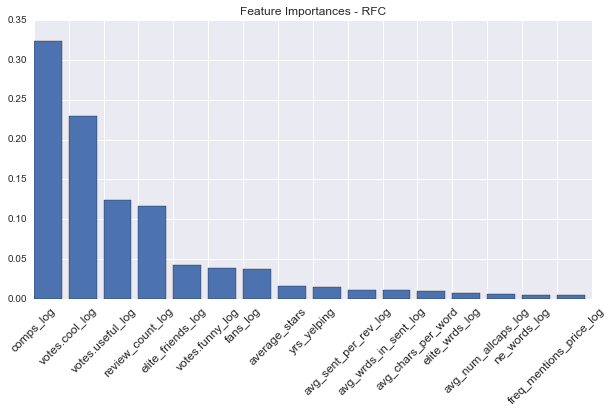

In [557]:
plt.figure(figsize = (10, 5))
plt.bar(range(len(Xtest.columns)), final_rf_nopl.feature_importances_[indices])
plt.xticks(range(len(Xtest.columns)), [Xtest.columns[i] for i in indices], rotation = 45, fontsize = 12)
plt.title('Feature Importances - RFC')
plt.show()

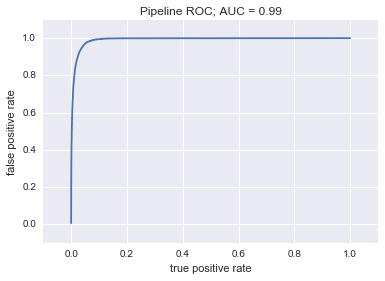

In [526]:
plot_roc(final_rf, Xtest, ytest)

baseline

In [567]:
def baseline_model(xtest, ytest):
    return np.array(xtest.shape[0] * [ytest.mode()])

In [569]:
baseline_pred = baseline_model(Xtest, ytest)

In [574]:
print 'accuracy:', accuracy_score(ytest, baseline_pred)
print 'precision:', precision_score(ytest, baseline_pred, average = None)
print 'recall:', recall_score(ytest, baseline_pred, average = None)
print 'f1:', f1_score(ytest, baseline_pred, average = None)

accuracy: 0.94325234457
precision: [ 0.94325234  0.        ]
recall: [ 1.  0.]
f1: [ 0.97079759  0.        ]


//anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
tpr = tp / (tp + fn)

In [ ]:
fpr = fp / (fp + tn)

In [ ]:
plot_roc()

In [519]:
# need to redefine these... accidentally deleted cell
best_sgd_final
best_rf_final 

SGDClassifier(alpha=1e-05, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=50, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [387]:
best_sgd = SGDClassifier(alpha = .0001, loss = 'hinge', penalty= 'l1', n_iter = 50)
best_rf = RandomForestClassifier(50)
best_logit = LogisticRegression()

test comps/votes

In [391]:
comps_features_log = [c for c in users.columns if "log" in c and "compliments." in c]
votes_features_log = [c for c in users.columns if "log" in c and "votes." in c]

In [402]:
eval_models_incr(['comps_log'], users, best_sgd)

['compliments.plain_log']
acc: 0.797521984589
precision: 0.830420735771
recall: 0.882205029014 

['compliments.plain_log', 'compliments.cute_log']
acc: 0.797461630468
precision: 0.820425479966
recall: 0.883251103077 



In [416]:
eval_models_incr(comps_features_log, users, best_sgd)

['compliments.plain_log']
acc: 0.965904974969
precision: 0.839206234956
recall: 0.488195539452 

['compliments.plain_log', 'compliments.cute_log']
acc: 0.954721013261
precision: 0.64612857713
recall: 0.439541579452 

['compliments.plain_log', 'compliments.cute_log', 'compliments.writer_log']
acc: 0.967828912867
precision: 0.805308815798
recall: 0.575515465561 

['compliments.plain_log', 'compliments.cute_log', 'compliments.writer_log', 'compliments.note_log']
acc: 0.967326813757
precision: 0.699927211258
recall: 0.770754746517 

['compliments.plain_log', 'compliments.cute_log', 'compliments.writer_log', 'compliments.note_log', 'compliments.hot_log']
acc: 0.97128815355
precision: 0.727422323932
recall: 0.780381734461 

['compliments.plain_log', 'compliments.cute_log', 'compliments.writer_log', 'compliments.note_log', 'compliments.hot_log', 'compliments.cool_log']
acc: 0.970899492478
precision: 0.732091678667
recall: 0.780143051725 

['compliments.plain_log', 'compliments.cute_log', 'com

end compliments/votes testing

In [356]:
# best one for now
eval_models_pl(edited_features, users, [SGDClassifier(
            alpha = .0001, loss = 'log', penalty= 'l1', n_iter = 50)])

done with SGDClassifier


[('SGDClassifier',
  0.97594470960586999,
  0.82157116211820058,
  0.75357984878239681)]

In [355]:
eval_models_pl(edited_features, users, [SGDClassifier(
            alpha = .0001, loss = 'hinge', penalty= 'l1', n_iter = 50)])

done with SGDClassifier


[('SGDClassifier',
  0.97615231181720785,
  0.81009013720111755,
  0.75981443516596259)]

In [354]:
eval_models_pl(edited_features, users, [SGDClassifier(
            alpha = .0001, loss = 'hinge', penalty= 'l1', n_iter = 10)])

done with SGDClassifier


[('SGDClassifier',
  0.97573469494178222,
  0.80839598569956106,
  0.75342834510424073)]

In [321]:
gs_scores

defaultdict(list,
            {'accuracy': (0.97613300052624719,
              {'sgdclassifier__alpha': 0.0001,
               'sgdclassifier__loss': 'log',
               'sgdclassifier__penalty': 'elasticnet'}),
             'f1': (0.78858002061339139,
              {'sgdclassifier__alpha': 0.0001,
               'sgdclassifier__loss': 'hinge',
               'sgdclassifier__penalty': 'l1'}),
             'precision': (0.85478216887885283,
              {'sgdclassifier__alpha': 1e-06,
               'sgdclassifier__loss': 'log',
               'sgdclassifier__penalty': 'l1'}),
             'recall': (0.82112876148121028,
              {'sgdclassifier__alpha': 1e-05,
               'sgdclassifier__loss': 'squared_hinge',
               'sgdclassifier__penalty': 'none'})})

In [330]:
np.ceil(10**6 / users.shape[0])

1.0

In [323]:
# best f1
eval_models_pl(edited_features, users, [SGDClassifier(alpha = .0001, loss = 'hinge', penalty= 'l1')])

done with SGDClassifier


[('SGDClassifier',
  0.97577573790431382,
  0.7981300052051773,
  0.76137945501488358)]

In [324]:
# best precision
eval_models_pl(edited_features, users, [SGDClassifier(
            alpha = .000001, loss = 'log', penalty= 'l1')])

done with SGDClassifier


[('SGDClassifier',
  0.9680268726479172,
  0.71433428902916163,
  0.72267783961861198)]

In [325]:
# best recall
eval_models_pl(edited_features, users, [SGDClassifier(
            alpha = .00001, loss = 'squared_hinge', penalty= 'none')])

done with SGDClassifier


[('SGDClassifier',
  0.96294545032926793,
  0.76357422536175734,
  0.77241759325914816)]

In [326]:
eval_models_pl(edited_features, users, [SGDClassifier(loss = 'hinge')]) #scaled 

done with SGDClassifier


[('SGDClassifier',
  0.97551743098432253,
  0.80868607582855057,
  0.74475937807603043)]

In [300]:
pipeline = make_pipeline(StandardScaler(), SGDClassifier())
param = {
    'sgdclassifier__loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
    'sgdclassifier__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'sgdclassifier__alpha': [0.0001, 0.00001, 0.000001]}
grid_search = GridSearchCV(pipeline, param_grid = param, verbose = 3, cv = 5) 

In [301]:
grid_search.fit(Xtrain, ytrain)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] sgdclassifier__penalty=l1, sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge 
[CV]  sgdclassifier__penalty=l1, sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, score=0.975969 -   0.8s
[CV] sgdclassifier__penalty=l1, sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge 
[CV]  sgdclassifier__penalty=l1, sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, score=0.976621 -   0.9s
[CV] sgdclassifier__penalty=l1, sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge 
[CV]  sgdclassifier__penalty=l1, sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, score=0.976367 -   0.8s
[CV] sgdclassifier__penalty=l1, sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge 
[CV]  sgdclassifier__penalty=l1, sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, score=0.975667 -   0.8s
[CV] sgdclassifier__penalty=l1, sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge 
[CV]  sgdclassifier__penalty=l1, sgdclassifier

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:   26.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:  1.8min



[CV] sgdclassifier__penalty=l2, sgdclassifier__alpha=1e-05, sgdclassifier__loss=log 
[CV]  sgdclassifier__penalty=l2, sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, score=0.973169 -   0.9s
[CV] sgdclassifier__penalty=l2, sgdclassifier__alpha=1e-05, sgdclassifier__loss=log 
[CV]  sgdclassifier__penalty=l2, sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, score=0.975196 -   0.9s
[CV] sgdclassifier__penalty=l2, sgdclassifier__alpha=1e-05, sgdclassifier__loss=log 
[CV]  sgdclassifier__penalty=l2, sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, score=0.972505 -   1.0s
[CV] sgdclassifier__penalty=elasticnet, sgdclassifier__alpha=1e-05, sgdclassifier__loss=log 
[CV]  sgdclassifier__penalty=elasticnet, sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, score=0.971069 -   1.1s
[CV] sgdclassifier__penalty=elasticnet, sgdclassifier__alpha=1e-05, sgdclassifier__loss=log 
[CV]  sgdclassifier__penalty=elasticnet, sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, score=0.975872 -

[Parallel(n_jobs=1)]: Done 287 tasks       | elapsed:  4.0min
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  4.2min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sgdclassifier', SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'sgdclassifier__penalty': ['l1', 'l2', 'elasticnet', 'none'], 'sgdclassifier__loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'], 'sgdclassifier__alpha': [0.0001, 1e-05, 1e-06]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=3)

In [302]:
grid_search.best_params_

{'sgdclassifier__alpha': 0.0001,
 'sgdclassifier__loss': 'log',
 'sgdclassifier__penalty': 'elasticnet'}

In [447]:
ugh = sorted(grid_search.grid_scores_, reverse = True)

In [448]:
ugh

[mean: 0.97560, std: 0.00040, params: {'sgdclassifier__penalty': 'none', 'sgdclassifier__alpha': 0.0001, 'sgdclassifier__loss': 'squared_hinge'},
 mean: 0.97187, std: 0.00344, params: {'sgdclassifier__penalty': 'l2', 'sgdclassifier__alpha': 0.0001, 'sgdclassifier__loss': 'squared_hinge'},
 mean: 0.97569, std: 0.00041, params: {'sgdclassifier__penalty': 'l1', 'sgdclassifier__alpha': 0.0001, 'sgdclassifier__loss': 'squared_hinge'},
 mean: 0.96657, std: 0.00613, params: {'sgdclassifier__penalty': 'elasticnet', 'sgdclassifier__alpha': 0.0001, 'sgdclassifier__loss': 'squared_hinge'},
 mean: 0.97569, std: 0.00047, params: {'sgdclassifier__penalty': 'none', 'sgdclassifier__alpha': 0.0001, 'sgdclassifier__loss': 'perceptron'},
 mean: 0.97128, std: 0.00370, params: {'sgdclassifier__penalty': 'l2', 'sgdclassifier__alpha': 0.0001, 'sgdclassifier__loss': 'perceptron'},
 mean: 0.97572, std: 0.00037, params: {'sgdclassifier__penalty': 'l1', 'sgdclassifier__alpha': 0.0001, 'sgdclassifier__loss': 'per

In [343]:
print grid_search.grid_scores_[0]

mean: 0.97560, std: 0.00040, params: {'sgdclassifier__penalty': 'none', 'sgdclassifier__alpha': 0.0001, 'sgdclassifier__loss': 'squared_hinge'}


In [ ]:
# SGD
eval_models(edited_features, users, [SGDClassifier(loss = 'log')])

In [265]:
eval_models_pl(edited_features, users, [SGDClassifier(loss = 'hinge')]) # normalized, not scaled

done with SGDClassifier


[('SGDClassifier',
  0.97428630236379732,
  0.80385959104621452,
  0.73565904893196765)]

In [267]:
eval_models_pl(edited_features, users, [SGDClassifier(loss = 'hinge')]) #scaled 

done with SGDClassifier


[('SGDClassifier',
  0.97564778809561103,
  0.81245053332211659,
  0.75539472922534068)]

In [268]:
eval_models_pl(edited_features, users, [SGDClassifier(loss = 'log')]) #scaled 

done with SGDClassifier


[('SGDClassifier',
  0.97571296770146498,
  0.81643814749405497,
  0.74795962534781857)]

In [236]:
# with ari score
eval_models(edited_features, users, [LogisticRegression()])

done with LogisticRegression


[('LogisticRegression',
  0.97567675435914869,
  0.81483572782200397,
  0.74026826687021852)]

In [251]:
# with ari score log
eval_models(edited_features, users, [LogisticRegression()])

done with LogisticRegression


[('LogisticRegression',
  0.97611610310884078,
  0.81924270772175178,
  0.74546610169491534)]

In [99]:
# without ari score
eval_models(edited_features, users, [LogisticRegression()])

done with LogisticRegression


[('LogisticRegression',
  0.97586987679217785,
  0.81636275699906802,
  0.74419983065198969)]

In [255]:
eval_models(log_features, users, [RandomForestClassifier(20)])

done with RandomForestClassifier


[('RandomForestClassifier',
  0.97705996959204255,
  0.83300761356194974,
  0.74631632214280819)]

In [244]:
# best random forest model?
eval_models(edited_features, users, [RandomForestClassifier(20)])

done with RandomForestClassifier


[('RandomForestClassifier',
  0.97693926801664444,
  0.82886626682736575,
  0.75067352472089321)]

In [246]:
eval_models(log_features, users, [RandomForestClassifier()])

done with RandomForestClassifier


[('RandomForestClassifier',
  0.97615955320195513,
  0.83163002911841333,
  0.72573771016836497)]

In [90]:
eval_models_incr(edited_features, users, LogisticRegression())

['review_count_log']
acc: 0.967609250148
precision: 0.760569967837
recall: 0.629334463756 

['review_count_log', 'comps_log']
acc: 0.974534951484
precision: 0.813704370887
recall: 0.715984753782 

['review_count_log', 'comps_log', 'fans_log']
acc: 0.974607371812
precision: 0.813394610742
recall: 0.720728806078 

['review_count_log', 'comps_log', 'fans_log', 'friends_num_log']
acc: 0.974802898512
precision: 0.812829983231
recall: 0.72463002247 

['review_count_log', 'comps_log', 'fans_log', 'friends_num_log', 'average_stars']
acc: 0.974752204891
precision: 0.812207594974
recall: 0.724054268909 

['review_count_log', 'comps_log', 'fans_log', 'friends_num_log', 'average_stars', 'avg_sent_per_rev_log']
acc: 0.974986363131
precision: 0.814224979351
recall: 0.726293469042 

['review_count_log', 'comps_log', 'fans_log', 'friends_num_log', 'average_stars', 'avg_sent_per_rev_log', 'avg_wrds_in_sent_log']
acc: 0.975049123077
precision: 0.815056128608
recall: 0.726937367619 

['review_count_log',

In [35]:
eval_models_incr(log_features, users, LogisticRegression())

['review_count_log']
acc: 0.967464405621
precision: 0.758616099885
recall: 0.629258129023 

['review_count_log', 'tips_log']
acc: 0.967512686955
precision: 0.759982945075
recall: 0.62696303682 

['review_count_log', 'tips_log', 'yrs_yelping']
acc: 0.967587517408
precision: 0.760497248551
recall: 0.631743468468 

['review_count_log', 'tips_log', 'yrs_yelping', 'comps_log']
acc: 0.975242241083
precision: 0.82051828236
recall: 0.725787516665 

['review_count_log', 'tips_log', 'yrs_yelping', 'comps_log', 'votes_log']
acc: 0.974971877262
precision: 0.81759888609
recall: 0.723006529288 

['review_count_log', 'tips_log', 'yrs_yelping', 'comps_log', 'votes_log', 'fans_log']
acc: 0.975034643972
precision: 0.815361962608
recall: 0.724886671034 

['review_count_log', 'tips_log', 'yrs_yelping', 'comps_log', 'votes_log', 'fans_log', 'friends_num_log']
acc: 0.975382254115
precision: 0.816467862973
recall: 0.732561821845 

['review_count_log', 'tips_log', 'yrs_yelping', 'comps_log', 'votes_log', 'fan

In [37]:
eval_models_incr(log_features, users, RandomForestClassifier(50))

['review_count_log']
acc: 0.967247150814
precision: 0.733929943845
recall: 0.668494741987 

['review_count_log', 'tips_log']
acc: 0.965914632813
precision: 0.729072384123
recall: 0.636518408172 

['review_count_log', 'tips_log', 'yrs_yelping']
acc: 0.963300293689
precision: 0.705323415304
recall: 0.603547090477 

['review_count_log', 'tips_log', 'yrs_yelping', 'comps_log']
acc: 0.971879570181
precision: 0.76070257616
recall: 0.747582537414 

['review_count_log', 'tips_log', 'yrs_yelping', 'comps_log', 'votes_log']
acc: 0.974996016165
precision: 0.797397949953
recall: 0.749957850946 

['review_count_log', 'tips_log', 'yrs_yelping', 'comps_log', 'votes_log', 'fans_log']
acc: 0.975908501163
precision: 0.808908054271
recall: 0.756753072055 

['review_count_log', 'tips_log', 'yrs_yelping', 'comps_log', 'votes_log', 'fans_log', 'friends_num_log']
acc: 0.976174038061
precision: 0.814933460866
recall: 0.755091043325 

['review_count_log', 'tips_log', 'yrs_yelping', 'comps_log', 'votes_log', 'f

In [23]:
# old
# log_features = ['yrs_yelping', 'review_count_log', 'fans_log',
#                 'friends_num_log', 'votes_log', 'comps_log', 'tips_log', 'average_stars']

estimators = [LogisticRegression(), RandomForestClassifier(50)]
# GaussianNB(), SVC(), DecisionTreeClassifier(), RandomForestClassifier(), 
%time eval_models(estimators, Xtrain, Xtest, ytrain, ytest)

done with LogisticRegression
done with RandomForestClassifier
CPU times: user 4min 30s, sys: 9.6 s, total: 4min 39s
Wall time: 4min 45s


[('LogisticRegression',
  0.97537984057981419,
  0.81677365393929713,
  0.73329728806603323),
 ('RandomForestClassifier',
  0.97698996239832048,
  0.82341852091515322,
  0.76006453813611041)]

In [130]:
# review features only 
review_features = ['avg_wrds_per_rev', 'avg_sent_per_rev', 'avg_wrds_in_sent', 'avg_num_para',
                  'freq_mentions_price', 'avg_num_allcaps', 'avg_num_excl']

Xtrain_r, Xtest_r, ytrain_r, ytest_r = train_test_split(
    users[review_features], users.is_elite, test_size = .25)

In [131]:
estimators = [LogisticRegression(), RandomForestClassifier(50), DecisionTreeClassifier(), GaussianNB()]
# SVC()
eval_models(estimators, Xtrain_r, Xtest_r, ytrain_r, ytest_r)

done with LogisticRegression
done with RandomForestClassifier
done with DecisionTreeClassifier
done with GaussianNB


[('LogisticRegression',
  0.94075856745404085,
  0.13201295040422695,
  0.0072060840876594853),
 ('RandomForestClassifier',
  0.94118584365724978,
  0.40046514553842288,
  0.065236786412939646),
 ('DecisionTreeClassifier',
  0.90833884740392767,
  0.19672547896627088,
  0.19719415554322486),
 ('GaussianNB', 0.89668656625481091, 0.17791950878314289, 0.22478909454900822)]

In [132]:
# get logit coefficients
rev_model = LogisticRegression().fit(Xtrain_r, ytrain_r)
zip(review_features, [i for sl in rev_model.coef_.tolist() for i in sl])

[('avg_wrds_per_rev', -0.0019633557820314977),
 ('avg_sent_per_rev', 0.03660098979107628),
 ('avg_wrds_in_sent', 0.014620771783887172),
 ('avg_num_para', 0.3308807625209637),
 ('freq_mentions_price', 0.3935434978261053),
 ('avg_num_allcaps', -0.05056917758992337),
 ('avg_num_excl', -0.02996208006881122)]

In [83]:
eval_models_classes(estimators, Xtrain, Xtest, ytrain, ytest)


LogisticRegression
[0 1]
accuracy: 0.975628479146
precision: [ 0.9841097   0.81875088]
recall: [ 0.99014114  0.73584028]
f1: [ 0.9871162   0.77508466]

RandomForestClassifier
[0 1]
accuracy: 0.998158134864
precision: [ 0.99835097  0.99489487]
recall: [ 0.99969791  0.97271689]
f1: [ 0.99902399  0.98368089]

DecisionTreeClassifier
[0 1]
accuracy: 1.0
precision: [ 1.  1.]
recall: [ 1.  1.]
f1: [ 1.  1.]

GaussianNB
[0 1]
accuracy: 0.93557334389
precision: [ 0.99661576  0.46815047]
recall: [ 0.93484856  0.94754875]
f1: [ 0.96474452  0.62668028]


In [47]:
# get logit coefficients
log_model = LogisticRegression().fit(Xtrain, ytrain)
zip(log_features, [i for sl in log_model.coef_.tolist() for i in sl])

[('review_count_log', -0.2083354616669469),
 ('tips_log', 1.4589541774045975),
 ('yrs_yelping', 0.07152427267001327),
 ('comps_log', 0.11608396518337506),
 ('votes_log', 0.07624723606581008),
 ('fans_log', 0.682358819032924),
 ('friends_num_log', -0.04375643820222756),
 ('average_stars', 0.5039057606540709),
 ('avg_wrds_per_rev_log', 0.0020679078045007402),
 ('avg_sent_per_rev_log', 0.004435654835354616),
 ('avg_wrds_in_sent_log', 0.007602737391004793),
 ('avg_num_para_log', 0.023786112188157408),
 ('freq_mentions_price_log', -0.07963912959461797),
 ('avg_num_allcaps_log', -0.08079993107987744),
 ('avg_num_excl_log', -0.04093221285529909)]

In [162]:
log_model.intercept_

array([-10.45717384])

### Investigate incorrect predictions

In [107]:
def split_results(predicted, actual, keep):
    """Create four dataframes (tp, tn, fp, fn) from predicted results.
    Keep only specified dataframe columns from original dataframe.
    """
    all_df = pd.DataFrame({'pred': predicted, 'actual': actual})
    all_df = pd.merge(all_df, users, left_index = True, right_index = True)
    all_df = all_df[keep]
    tp = all_df[(all_df.pred == all_df.actual) & (all_df.actual == 1)]
    tn = all_df[(all_df.pred == all_df.actual) & (all_df.actual == 0)]
    fp = all_df[(all_df.pred != all_df.actual) & (all_df.actual == 0)]
    fn = all_df[(all_df.pred != all_df.actual) & (all_df.actual == 1)]
    return (tp, tn, fp, fn)

In [151]:
def get_diff(df1, df2, col_name1, col_name2):
    """Get new comparative dataframe between two prediction types
    and sort by features with greatest standardized difference.
    """
    df = pd.DataFrame({col_name1 : df1.describe().loc['mean', :], col_name2 : df2.describe().loc['mean', :]})
    df['diff'] = abs((df[col_name1] - df[col_name2]) / df[col_name2])
    df.sort_values(by = 'diff', ascending = False, inplace = True)
    return df

In [46]:
keep = ['pred', 'actual', 'yrs_yelping', 'review_count', 'fans', 'average_stars', 'votes', 'comps', 'elite_yrs',
       'friends_num', 'votes.cool', 'votes.funny', 'votes.useful']
train_pred = log_model.predict(Xtrain)
tp, tn, fp, fn = split_results(train_pred, ytrain, keep)

NameError: name 'log_model' is not defined

In [45]:
fn.shape

NameError: name 'fn' is not defined

**True positives vs. false positives**

In [158]:
get_diff(tp, fp, 'tp', 'fp')

,fp,tp,diff
actual,0.000000,1.000000,inf
elite_yrs,0.000000,3.372703,inf
comps,112.084493,414.575812,2.698779
votes.cool,167.772282,527.501502,2.144152
votes.funny,162.983771,449.624870,1.758709
votes,655.774343,1784.767711,1.721619
votes.useful,325.018290,807.641338,1.484910
fans,8.673622,20.739512,1.391102
friends_num,46.330757,75.082226,0.620570
review_count,209.761978,298.900728,0.424952


**False negative vs. true negative**

In [159]:
get_diff(tn, fn, 'tn', 'fn')

,fn,tn,diff
actual,1.000000,0.000000,1.000000
elite_yrs,1.542853,0.000000,1.000000
comps,17.191176,1.215361,0.929303
votes.cool,40.188963,4.138780,0.897017
votes.funny,35.271505,4.249257,0.879527
votes,179.696869,22.100532,0.877012
fans,2.809140,0.364093,0.870390
votes.useful,104.236401,13.712496,0.868448
review_count,82.197343,12.746803,0.844924
friends_num,10.313409,2.920443,0.716830


**False positive vs. true negative**

In [160]:
get_diff(fp, tn, 'fp', 'tn')

,fp,tn,diff
pred,1.000000,0.000000,inf
comps,112.084493,1.215361,91.223238
votes.cool,167.772282,4.138780,39.536653
votes.funny,162.983771,4.249257,37.355832
votes,655.774343,22.100532,28.672333
fans,8.673622,0.364093,22.822554
votes.useful,325.018290,13.712496,22.702344
review_count,209.761978,12.746803,15.456046
friends_num,46.330757,2.920443,14.864290
yrs_yelping,6.058733,3.892370,0.556566


**False negative vs. true positive**

In [155]:
get_diff(fn, tp, 'fn', 'tp')

,fn,tp,diff
pred,0.000000,1.000000,1.000000
comps,17.191176,414.575812,0.958533
votes,179.696869,1784.767711,0.899316
fans,2.809140,20.739512,0.864551
friends_num,10.313409,75.082226,0.862638
review_count,82.197343,298.900728,0.725001
elite_yrs,1.542853,3.372703,0.542547
yrs_yelping,5.762334,6.441234,0.105399
average_stars,3.808972,3.800864,0.002133
actual,1.000000,1.000000,0.000000


In decreasing order of importance -- differences in 1) compliments, 2) votes, 3) fans, and 4) friends account for false classification.

#### Try model without normalizing

In [ ]:
reg_features = ['yrs_yelping', 'review_count', 'fans',
                'friends_num', 'votes', 'comps', 'average_stars']
Xtrain_reg, Xtest_reg, ytrain_reg, ytest_reg = train_test_split(
    users[reg_features], users.is_elite, test_size = .25)

In [39]:
reg_model = LogisticRegression().fit(Xtrain_reg, ytrain_reg)
zip(reg_features, [i for sl in reg_model.coef_.tolist() for i in sl])

[('yrs_yelping', 0.09295183366496168),
 ('review_count', 0.02156069847814853),
 ('fans', 0.06575687053124128),
 ('friends_num', 0.006658284514994196),
 ('votes', 0.0011006400568146601),
 ('comps', -0.000770933115982151),
 ('average_stars', 0.11169297411135241)]

In [47]:
reg_pred = reg_model.predict(Xtest_reg)
print 'acc: ', accuracy_score(ytest_reg, reg_pred)
print 'precision: ', precision_score(ytest_reg, reg_pred)
print 'recall: ', recall_score(ytest_reg, reg_pred)

acc:  0.96809935909
precision:  0.816975135539
recall:  0.560543868651


### exploratory charts

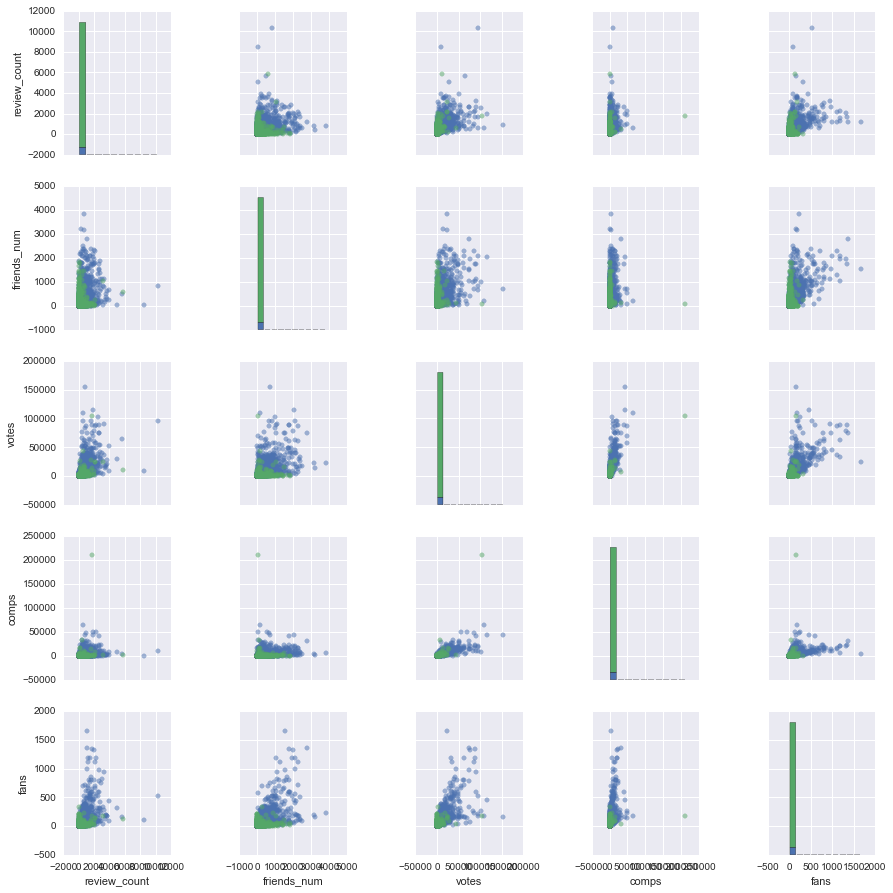

In [25]:
features = ['review_count', 'friends_num', 'votes', 'comps', 'fans']
plot = sns.PairGrid(users, vars = features, hue = 'is_elite', palette = "Set2")
plot.map_diag(plt.hist)
plot.map_upper(plt.scatter, alpha = 0.5)
plot.map_lower(plt.scatter, alpha = 0.5)
plt.tight_layout()
#plt.savefig('yelp-pairplot.png', dpi = 500)
plt.show()

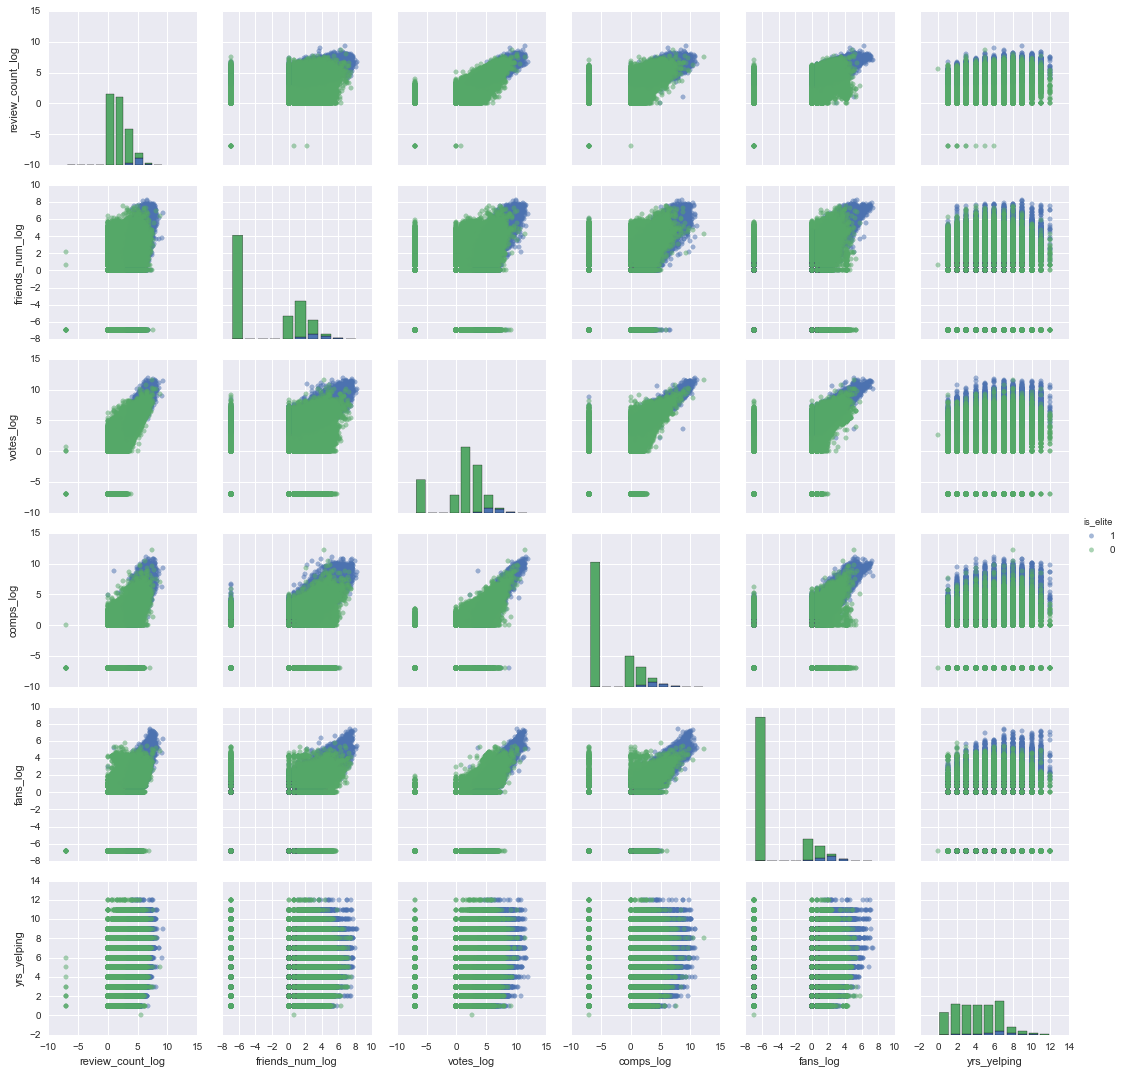

In [18]:
log_features = ['review_count_log', 'friends_num_log', 
                'votes_log', 'comps_log', 'fans_log', 'yrs_yelping']
plot = sns.PairGrid(users, vars = log_features, hue = 'is_elite')
plot.map_diag(plt.hist)
plot.map_upper(plt.scatter, alpha = 0.5)
plot.map_lower(plt.scatter, alpha = 0.5)
plot.add_legend();

In [ ]:
sns.corrplot(users[log_features])

In [93]:
ys = ['friends_num_log', 'votes_log', 'comps_log', 'elite_yrs_log']

scores = []
for i in ys:  
    X = u.review_count_log
    y = u[i]
    m = sm.OLS(y, X)
    m = m.fit()
    scores.append(m.rsquared)

print zip(ys, scores)

[('friends_num_log', 0.059813958743482387), ('votes_log', 0.37312353481806337), ('comps_log', 0.061463678374059416), ('elite_yrs_log', 0.45580717865596876)]


In [ ]:
'''
- add total votes
- add total compliments
- add friends + fans
- add years elite
- add elite vs. not elite
- plot popularity vs. number of reviews'''

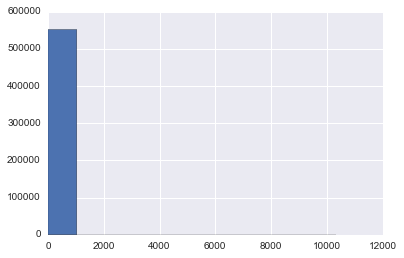

In [15]:
plt.hist(users.review_count)
plt.show()

In [51]:
users.review_count.describe()

count    552339.000000
mean         27.631737
std          87.741127
min           0.000000
25%           2.000000
50%           6.000000
75%          18.000000
max       10320.000000
Name: review_count, dtype: float64

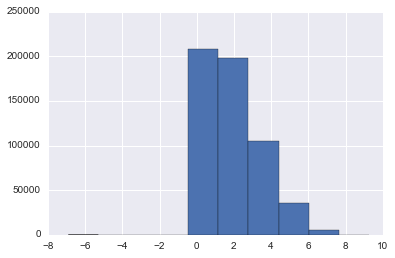

In [16]:
plt.hist(users.review_count_log);

In [25]:
review_count_norm = normalize(users.review_count.reshape(-1, 1), norm = 'l1')

//anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, DataConversionWarning)


In [30]:
review_count_scaled = scale(users.review_count.reshape(-1, 1))

//anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


(array([  5.51785000e+05,   4.92000000e+02,   4.40000000e+01,
          1.30000000e+01,   1.00000000e+00,   2.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          1.00000000e+00]),
 array([  -0.31492372,   11.44696004,   23.2088438 ,   34.97072757,
          46.73261133,   58.49449509,   70.25637885,   82.01826261,
          93.78014638,  105.54203014,  117.3039139 ]),
 <a list of 10 Patch objects>)

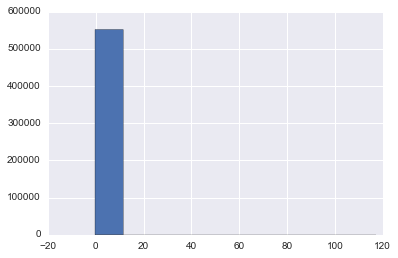

In [33]:
plt.hist(review_count_scaled)

(array([  1.10000000e+01,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          5.52328000e+05]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

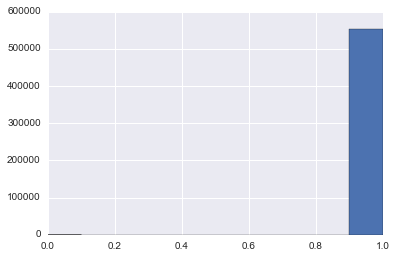

In [26]:
plt.hist(review_count_norm)

In [ ]:
print 'test'

In [11]:
users.review_count.describe()

count    552339.000000
mean         27.631737
std          87.741127
min           0.000000
25%           2.000000
50%           6.000000
75%          18.000000
max       10320.000000
Name: review_count, dtype: float64

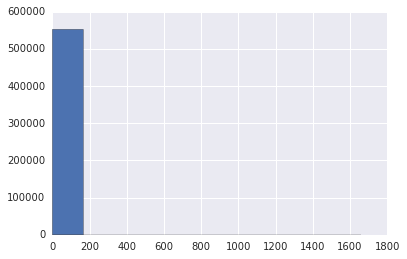

In [8]:
plt.hist(users.fans);

In [15]:
users.fans.describe()

count    552339.000000
mean          1.331508
std          10.798539
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        1657.000000
Name: fans, dtype: float64

In [3]:
reviews = pd.read_csv('data/yelp_academic_dataset_review.csv')

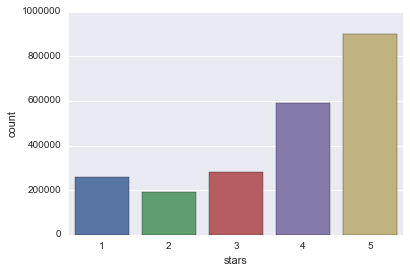

In [7]:
sns.countplot('stars', data = reviews, order = [1, 2, 3, 4, 5]);